# Implementation

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import string
import pandas as pd
import requests
from io import BytesIO

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.applications import EfficientNetB4
from keras.models import Sequential
from keras.layers import Reshape, Bidirectional, Flatten
from keras.models import Model
from keras.layers import Input, Embedding, Dropout, Dense
from keras.layers import GRU
from keras.layers import concatenate
from keras.optimizers import Adam
import matplotlib.image as mpimg
from tqdm import tqdm

In [ ]:
IMAGE_SIZE = (380, 380)
LR = 3e-4
SEQ_LEN = 25
VOCAB_SIZE = 9234
EMBED_DIM = 128
FF_DIM = 256
GRU_DIM = 256
DROPOUT = 0.3
TOKENIZER_PATH = './drive/MyDrive/LICENTA-MODELS/tokenizer.pickle'
MODEL_PATH = './drive/MyDrive/LICENTA-MODELS/EfficientNetB4-v4-10.tf'

tokenizer = None
with open(TOKENIZER_PATH, 'rb') as handle:
    tokenizer = pickle.load(handle)

In [ ]:
def get_cnn_model():
    model = EfficientNetB4()
    model.trainable = False
    model.layers.pop()
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output) #  put -2
    # model.summary()

    return model, model.layers[-1].output_shape[-1]

def define_model_GRU_CONC(vocab_size, max_length, in_shape, embed_dim, ff_dim, gru_dim, dropout):
    inputs1 = Input(shape=(in_shape,))
    fe1 = Dropout(dropout)(inputs1)
    fe2 = Dense(ff_dim, activation='relu')(fe1)

    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, embed_dim, mask_zero=True)(inputs2)
    se2 = Dropout(dropout)(se1)
    se3 = GRU(gru_dim)(se2)

    decoder1 = concatenate([fe2, se3])
    decoder2 = Dense(ff_dim, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)

    return model

In [ ]:
cnn_model, out_shape = get_cnn_model()
model = define_model_GRU_CONC(
    VOCAB_SIZE,
    SEQ_LEN + 2,
    out_shape,
    EMBED_DIM,
    FF_DIM,
    GRU_DIM,
    DROPOUT)

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=LR), metrics=['accuracy'])
model.load_weights(MODEL_PATH)

In [ ]:
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def preprocess_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.image.convert_image_dtype(img, tf.float32)
    # img = img_aug(img)
    return img

def decode_and_resize(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img


def generate_desc_batch(model, tokenizer, photos, max_length):
    batch_size = len(photos)
    in_texts = ['startseq'] * batch_size
    completed_descriptions = [''] * batch_size
    for i in range(max_length):
        sequences = tokenizer.texts_to_sequences(in_texts)
        sequences = pad_sequences(sequences, maxlen=max_length)
        yhat = model.predict([photos, sequences], verbose=0)
        yhat = np.argmax(yhat, axis=1)
        words = [word_for_id(y, tokenizer) for y in yhat]

        for j in range(batch_size):
            word = words[j]
            if word is None or word == 'endseq':
                continue
            in_texts[j] += ' ' + word
            completed_descriptions[j] = in_texts[j]

    completed_descriptions = [desc.replace("startseq ", "").replace(" endseq", "") for desc in completed_descriptions]
    return completed_descriptions


def beam_search_batch(model, tokenizer, photos, max_length, beam_width):
    batch_size = len(photos)
    start_seq = [tokenizer.texts_to_sequences(['startseq'])[0]] * batch_size
    sequences = [[[seq, 0.0]] for seq in start_seq]

    for _ in range(max_length):
        all_candidates = [[] for _ in range(batch_size)]

        for b in range(batch_size):
            for seq, score in sequences[b]:
                if seq[-1] == tokenizer.word_index['endseq']:
                    all_candidates[b].append([seq, score])
                    continue

                yhat = model.predict([np.expand_dims(photos[b], axis=0), pad_sequences([seq], maxlen=max_length)], verbose=0)
                top_words = np.argsort(yhat[0])[-beam_width:]

                for word in top_words:
                    new_seq = seq + [word]
                    new_score = score - np.log(yhat[0][word])
                    all_candidates[b].append([new_seq, new_score])

        sequences = []
        for b in range(batch_size):
            ordered = sorted(all_candidates[b], key=lambda tup: tup[1])
            sequences.append(ordered[:beam_width])

    final_sequences = [seq[0][0] for seq in sequences]
    descriptions = []
    for seq in final_sequences:
        desc = ' '.join([word_for_id(word, tokenizer) for word in seq if word != 0])
        descriptions.append(desc.replace("startseq ", "").replace(" endseq", ""))

    return descriptions

def batch_process_images(model, tokenizer, image_paths, batch_size, max_length, bw = 1):
    descriptions = []
    for i in tqdm(range(0, len(image_paths), batch_size)):
        batch_paths = image_paths[i:i + batch_size]
        photo_batch = [preprocess_image(path) for path in batch_paths]
        photo_features_batch = np.array([cnn_model(np.expand_dims(photo, axis=0)) for photo in photo_batch])
        photo_features_batch = np.squeeze(photo_features_batch, axis=1)
        batch_descriptions = generate_desc_batch(model, tokenizer, photo_features_batch, max_length) if bw == 1 else beam_search_batch(model, tokenizer, photo_features_batch, max_length, bw)
        descriptions.extend(batch_descriptions)
    return descriptions

# Local images

100%|██████████| 1/1 [00:11<00:00, 11.61s/it]


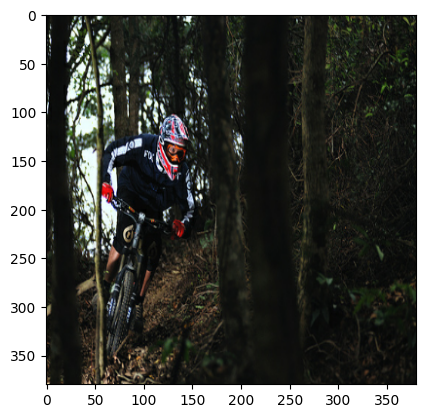

un motociclist de munte care merge cu bicicleta pe o potecă
un om care merge cu bicicleta prin pădure
un om care merge cu bicicleta prin pădure


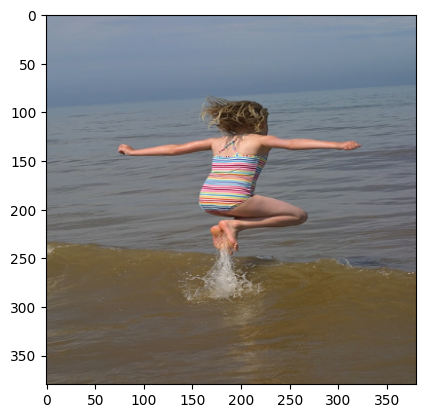

o fată tânără se plimbă pe plajă
o fată în costum de baie sare în apă
o fată în costum de baie sare în apă


In [ ]:
wanted = ["3299820401.jpg", "457945610.jpg"]

preds = batch_process_images(model, tokenizer, wanted, 2, SEQ_LEN + 2)
preds_beam_3 = batch_process_images(model, tokenizer, wanted, len(wanted), SEQ_LEN + 2, 3)
for idx, path in enumerate(wanted):
  img = decode_and_resize(path)
  img = img.numpy().clip(0, 255).astype(np.uint8)
  plt.imshow(img)
  plt.show()
  print(preds[idx])
  print(preds_beam_3[idx])

# Web images

In [ ]:
!wget https://humaneheroes.org/wp-content/uploads/2019/09/txhh_best-practices-when-taking-dog-park.png
!wget https://t4.ftcdn.net/jpg/02/03/51/79/360_F_203517987_aw4LW9Z37enxAuMFojbtHoYEi5k0vCvL.jpg

--2024-06-19 13:40:59--  https://humaneheroes.org/wp-content/uploads/2019/09/txhh_best-practices-when-taking-dog-park.png
Resolving humaneheroes.org (humaneheroes.org)... 141.193.213.10, 141.193.213.11
Connecting to humaneheroes.org (humaneheroes.org)|141.193.213.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 372855 (364K) [image/png]
Saving to: ‘txhh_best-practices-when-taking-dog-park.png.1’

txhh_best-practices 100%[===================>] 364.12K  --.-KB/s    in 0.006s  

2024-06-19 13:40:59 (63.6 MB/s) - ‘txhh_best-practices-when-taking-dog-park.png.1’ saved [372855/372855]

--2024-06-19 13:40:59--  https://t4.ftcdn.net/jpg/02/03/51/79/360_F_203517987_aw4LW9Z37enxAuMFojbtHoYEi5k0vCvL.jpg
Resolving t4.ftcdn.net (t4.ftcdn.net)... 151.101.1.167, 151.101.65.167, 151.101.129.167, ...
Connecting to t4.ftcdn.net (t4.ftcdn.net)|151.101.1.167|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46960 (46K) [image/jpeg]
Saving to: ‘360_F_2035

100%|██████████| 1/1 [00:12<00:00, 12.28s/it]


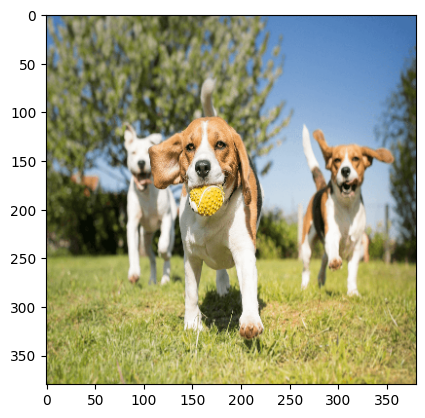

un câine maro și alb se joacă cu o minge roșie
un câine maro și alb se joacă cu o minge roșie
un câine maro și alb se joacă cu un frisbee


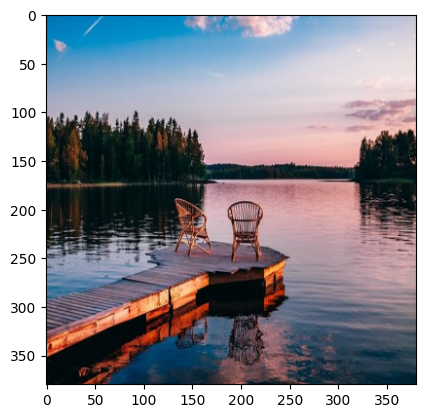

un bărbat și o femeie stau pe o punte de lemn și se uită la un pod
un bărbat și o femeie stau pe un doc lângă un lac
un grup de oameni se bucură de o zi frumoasă


In [ ]:
wanted = ["txhh_best-practices-when-taking-dog-park.png", "360_F_203517987_aw4LW9Z37enxAuMFojbtHoYEi5k0vCvL.jpg"]

preds = batch_process_images(model, tokenizer, wanted, 2, SEQ_LEN + 2)
preds_beam_3 = batch_process_images(model, tokenizer, wanted, len(wanted), SEQ_LEN + 2, 3)
for idx, path in enumerate(wanted):
  img = decode_and_resize(path)
  img = img.numpy().clip(0, 255).astype(np.uint8)
  plt.imshow(img)
  plt.show()
  print(preds[idx])
  print(preds_beam_3[idx])